In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [7]:
input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix02']
output_columns = ['temp_conv03']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 4), X_test: (14150, 4)
y_train: (21225, 1), y_test: (14150, 1)


In [9]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [10]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [11]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [12]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [13]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=4, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:00<07:08,  2.33it/s]

Epoch : 0, Train_loss: 0.7864079574743906, Test_loss: 0.5140777506998607


  5%|▌         | 51/1000 [00:16<05:02,  3.13it/s]

Epoch : 50, Train_loss: 0.0001050807006235811, Test_loss: 0.0067442465972687516


 10%|█         | 101/1000 [00:32<05:36,  2.67it/s]

Epoch : 100, Train_loss: 2.4878417856858244e-05, Test_loss: 0.0006500141324587665


 15%|█▌        | 151/1000 [00:46<04:40,  3.03it/s]

Epoch : 150, Train_loss: 1.2348439927986224e-05, Test_loss: 0.00028923841845036283


 20%|██        | 201/1000 [01:04<05:08,  2.59it/s]

Epoch : 200, Train_loss: 7.05786658814066e-06, Test_loss: 0.00027088060616214146


 25%|██▌       | 251/1000 [01:19<04:31,  2.76it/s]

Epoch : 250, Train_loss: 4.352233818714185e-06, Test_loss: 0.00028625162670843044


 30%|███       | 301/1000 [01:36<04:22,  2.66it/s]

Epoch : 300, Train_loss: 3.1330682975835987e-06, Test_loss: 0.00025711285236086823


 35%|███▌      | 351/1000 [01:53<04:11,  2.58it/s]

Epoch : 350, Train_loss: 2.4737053460436678e-06, Test_loss: 0.0001841338337596556


 40%|████      | 401/1000 [02:09<04:01,  2.48it/s]

Epoch : 400, Train_loss: 2.5494781322690653e-06, Test_loss: 0.00012046641828484488


 45%|████▌     | 451/1000 [02:28<04:46,  1.92it/s]

Epoch : 450, Train_loss: 2.501018516774084e-06, Test_loss: 0.00010198139843201457


 50%|█████     | 501/1000 [02:46<03:06,  2.67it/s]

Epoch : 500, Train_loss: 3.00370063433504e-06, Test_loss: 8.619238181901372e-05


 55%|█████▌    | 551/1000 [03:01<02:24,  3.10it/s]

Epoch : 550, Train_loss: 1.812168057941086e-06, Test_loss: 8.066672080531134e-05


 60%|██████    | 601/1000 [03:16<02:21,  2.81it/s]

Epoch : 600, Train_loss: 1.8351107087255514e-06, Test_loss: 7.851119684281522e-05


 65%|██████▌   | 651/1000 [03:32<02:01,  2.87it/s]

Epoch : 650, Train_loss: 1.8986171101330131e-06, Test_loss: 7.624652630511264e-05


 70%|███████   | 701/1000 [03:47<01:43,  2.88it/s]

Epoch : 700, Train_loss: 1.9952638743753984e-06, Test_loss: 7.281278203663533e-05


 75%|███████▌  | 751/1000 [04:03<01:25,  2.90it/s]

Epoch : 750, Train_loss: 1.7784224967596986e-06, Test_loss: 7.068790627532248e-05


 80%|████████  | 801/1000 [04:18<01:09,  2.85it/s]

Epoch : 800, Train_loss: 1.7517869483050335e-06, Test_loss: 6.650684857894313e-05


 85%|████████▌ | 851/1000 [04:34<00:52,  2.85it/s]

Epoch : 850, Train_loss: 1.7772423461792641e-06, Test_loss: 6.566442120207025e-05


 90%|█████████ | 901/1000 [04:49<00:35,  2.78it/s]

Epoch : 900, Train_loss: 1.7493035838491606e-06, Test_loss: 6.37072125592957e-05


 95%|█████████▌| 951/1000 [05:05<00:16,  2.95it/s]

Epoch : 950, Train_loss: 1.7919728390682264e-06, Test_loss: 6.286903335096992e-05


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


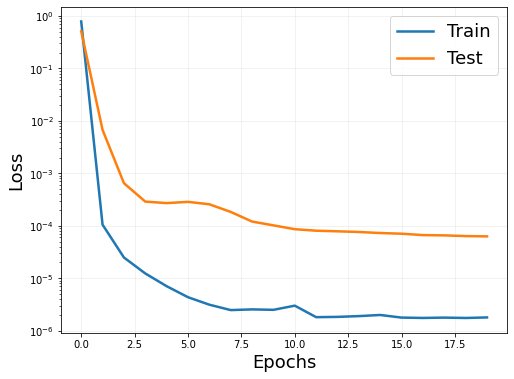

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [17]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.0453234022845198
L2 Error  of Temp: 0.003121399220383769


In [18]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.007789874222047012
L2 Error  of Temp: 0.000608549131618913


# Saving Model

In [19]:
PATH = f"./saved_models/convection_model_time.pth"
torch.save(model.state_dict(), PATH)

In [20]:
output_mean

array([11.34630318])